In [4]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
from datetime import datetime
from datetime import timedelta


def dps_all_f(city,entity,start_date, end_date):

    query = """
    with details as (
    SELECT   smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "post") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    join
    (   SELECT  o.customer_account_id
        FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
        WHERE o.entity_id = \"""" + entity + """\"
            AND (o.customer_first_order_date is null
            OR date(o.customer_first_order_date) = '0001-01-01')
            AND o.city_name in (""" + city + """)
            group by 1
    ) tm on tm.customer_account_id = smto.customer_account_id
    WHERE smto.created_date_local BETWEEN \"""" + start_date + """\" AND \"""" + end_date + """\"
    AND city_name in (""" + city + """)
    AND is_own_delivery = TRUE
    AND is_sent = TRUE
    ),
    voucher_data as (
    SELECT  o.global_entity_id
            ,order_id
            ,o.customer_account_id
            ,vouchers[SAFE_OFFSET(0)].voucher_code voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id = \"""" + entity + """\"
    AND partition_date_local BETWEEN \"""" + start_date + """\" AND \"""" + end_date + """\"
    )
    select d.*
           ,vd.voucher_amount_eur
    from details d 
    left join voucher_data vd on vd.global_entity_id = d.entity_id and vd.order_id = d.platform_order_code
    """

    return query


def sessions(entity, city, start_date, end_date):

    query = """
    SELECT count(distinct perseus_session_key) total_sessions,
       count(distinct sessions.perseus_client_id) total_users,
       count(distinct case when has_transaction = True then sessions.perseus_client_id else null end) total_orders,
       count(distinct case when has_transaction = True then sessions.perseus_client_id else null end) / count(distinct perseus_session_key)   
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
    WHERE created_date BETWEEN \"""" + start_date + """\" AND \"""" + end_date + """\"
    AND entity_id = \"""" + entity + """\" 
    and dps_zone[SAFE_OFFSET(0)].city_name in (""" + city + """)
    """
    
    return query

def analyze_city_orders(df, period):
    
   # Create a new column for the conditional forgone delivery fee
    df['foregone_delivery_fee'] = df.apply(
    lambda row: row['dps_standard_fee_eur'] if row['dps_delivery_fee_eur'] == 0 or pd.isnull(row['dps_delivery_fee_eur']) else 0,
    axis=1)

    df['entity_id_period'] = df['entity_id'] + '_' + period
        
    grouped_data_post = df.groupby('entity_id_period').agg({
        'platform_order_code': 'nunique',
        'customer_account_id': 'nunique',
        'gfv_eur': 'sum',
        'voucher_amount_eur': 'sum',
        'fully_loaded_gross_profit_eur': 'sum',
        'foregone_delivery_fee': 'sum'
    }).reset_index()

    grouped_data_post.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_data_post.columns]

    grouped_data_post = grouped_data_post.rename(columns={
        'platform_order_code': 'Orders',
        'customer_account_id': 'Acquistions',
        'voucher_amount_eur': 'Voucher_cost_eur',
        'gfv_eur':'GFV_eur',
        'fully_loaded_gross_profit_eur' : 'FLGP_eur',
        'foregone_delivery_fee': 'FDNC_cost_eur',
        })


    voucher_counts = df[(df['voucher_amount_eur'] > 0) & ((df['dps_delivery_fee_eur'] == 0) | (df['dps_delivery_fee_eur'].isna()))].groupby('entity_id_period')['platform_order_code'].nunique().reset_index()
    voucher_counts = voucher_counts.rename(columns={'platform_order_code': 'Stacked_orders'})

    grouped_data_post = grouped_data_post.merge(voucher_counts, on='entity_id_period', how='left').fillna(0)
    grouped_data_post[['GFV_eur','Voucher_cost_eur','FLGP_eur','FDNC_cost_eur']] = grouped_data_post[['GFV_eur','Voucher_cost_eur','FLGP_eur','FDNC_cost_eur']].astype(int)

    grouped_data_post['total_acquistion_cost'] = grouped_data_post['FDNC_cost_eur'] + grouped_data_post['Voucher_cost_eur']

    grouped_data_post = grouped_data_post[['entity_id_period','Orders','Stacked_orders','Acquistions','FDNC_cost_eur','Voucher_cost_eur','total_acquistion_cost','GFV_eur','FLGP_eur']]

    return grouped_data_post.round(0).set_index('entity_id_period').T

def cities_summary(pre_df, post_df):
    
    df2 = analyze_city_orders(pre_df, 'pre')
    df1 = analyze_city_orders(post_df, 'post')

    merged_df = pd.merge(df2, df1, left_index=True, right_index=True, how='outer')

    for col in merged_df.columns:
        if col.endswith('_post'):
            post = col
            pre = post.replace('_post', '_pre')  # Find the corresponding _pre column
            
            if pre in merged_df.columns:  # Ensure the _pre column exists
                # Calculate percentage change and store it in 'percentage_change'
                merged_df['percentage_change'] = round(
                    ((merged_df[post] - merged_df[pre]) / abs(merged_df[pre])) * 100, 0
                )
    
    return merged_df

def user_retention_wow(df):

    post_inter_df = df.copy()

    post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')
    post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

    total_users = post_inter_df['customer_account_id'].nunique()

    retention_df = post_inter_df.groupby('week_diff').agg(
        users_retained=('customer_account_id', 'nunique')
    ).reset_index()

    retention_df['wow_retention'] = round((retention_df['users_retained'] / retention_df['users_retained'][0]) * 100,2)
    
    return retention_df
  

# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:

# free_delivery = dps_pre_treatment[dps_pre_treatment['foregone_delivery_fee'] > 0]['platform_order_code'].nunique()

# print(free_delivery / dps_pre_treatment['platform_order_code'].nunique())

# voucher = dps_pre_treatment[dps_pre_treatment['voucher_amount_eur'] > 0]['platform_order_code'].nunique()

# print(voucher / dps_pre_treatment['platform_order_code'].nunique())



In [6]:
# a = dps_post_treatment[(dps_post_treatment['has_new_customer_condition'] == False) & (dps_post_treatment['new_customer_condition_type'] != 'TOTAL')]

# free_delivery = a[a['foregone_delivery_fee'] > 0]['platform_order_code'].nunique()

# print(free_delivery / a['platform_order_code'].nunique())

# voucher = a[a['voucher_amount_eur'] > 0]['platform_order_code'].nunique()

# print(voucher / a['platform_order_code'].nunique())

In [7]:
## Treatment Cities ##

entity_id = 'OP_SE'

city = ('Uppsala','Vasteras','Orebro','Stockholm')
city_str = ",".join([f"'{c}'" for c in city])

## post time period ##
start_date_post = '2024-08-06'
end_date_post = '2024-09-25'
dps_post_treatment = client.query(dps_all_f(city_str, entity_id, start_date_post, end_date_post)).to_dataframe()

## pre time period ##

# Convert the strings to datetime objects
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post, date_format)
end_date = datetime.strptime(end_date_post, date_format)

# Calculate the difference in days
days_difference = (end_date - start_date).days
days_difference

# Subtract the number of days from date1
new_date = start_date - timedelta(days=days_difference)
new_date_only = new_date.date()
new_date_string = new_date_only.strftime("%Y-%m-%d")

start_date_pre = new_date_string
end_date_pre = start_date_post
dps_pre_treatment = client.query(dps_all_f(city_str, entity_id, start_date_pre, end_date_pre)).to_dataframe()

cities_summary(dps_pre_treatment, dps_post_treatment)

entity_id_period,OP_SE_pre,OP_SE_post,percentage_change
Acquistions,229082,234342,2.0
FDNC_cost_eur,686811,527777,-23.0
FLGP_eur,2655412,2997043,13.0
GFV_eur,18095347,20233376,12.0
Orders,710202,782591,10.0
Stacked_orders,17419,24945,43.0
Voucher_cost_eur,413102,531225,29.0
total_acquistion_cost,1099913,1059002,-4.0


In [8]:
print(user_retention_wow(dps_post_treatment))
print(user_retention_wow(dps_pre_treatment))

   week_diff  users_retained  wow_retention
0          0          234342         100.00
1          1           60541          25.83
2          2           56422          24.08
3          3           50565          21.58
4          4           44616          19.04
5          5           35749          15.26
6          6           23534          10.04
7          7            3829           1.63
   week_diff  users_retained  wow_retention
0          0          229082         100.00
1          1           53941          23.55
2          2           46927          20.48
3          3           41553          18.14
4          4           38263          16.70
5          5           32313          14.11
6          6           20923           9.13
7          7            3282           1.43


In [9]:
post_sessions = client.query(sessions(entity_id, city_str, start_date_post, end_date_post)).to_dataframe()
pre_sessions = client.query(sessions(entity_id, city_str, start_date_pre, end_date_pre)).to_dataframe()

print(post_sessions , pre_sessions)

   total_sessions  total_users  total_orders      f0_
0         2751432       625573        301199  0.10947    total_sessions  total_users  total_orders      f0_
0         2603354       634288        290169  0.11146


In [10]:
## Control Cities ##

entity_id_control = 'OP_SE'

city = ('Umea','Malmo','Goteborg')
city_str_control = ",".join([f"'{c}'" for c in city])


## post time period ##
start_date_post_control = '2024-08-06'
end_date_post_control = '2024-09-25'
post_control = client.query(dps_all_f(city_str_control, entity_id_control, start_date_post_control, end_date_post_control)).to_dataframe()


## pre time period ##

# Convert the strings to datetime objects
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post, date_format)
end_date = datetime.strptime(end_date_post, date_format)

# Calculate the difference in days
days_difference = (end_date - start_date).days
days_difference

# Subtract the number of days from date1
new_date = start_date - timedelta(days=days_difference)
new_date_only = new_date.date()
new_date_string = new_date_only.strftime("%Y-%m-%d")

start_date_pre_control = new_date_string
end_date_pre_control = start_date_post
pre_control = client.query(dps_all_f(city_str_control, entity_id_control, start_date_pre_control, end_date_pre_control)).to_dataframe()

cities_summary(pre_control, post_control)

entity_id_period,OP_SE_pre,OP_SE_post,percentage_change
Acquistions,124350,126016,1.0
FDNC_cost_eur,405957,259647,-36.0
FLGP_eur,1997081,2175749,9.0
GFV_eur,10046624,10663190,6.0
Orders,404032,423205,5.0
Stacked_orders,8998,9933,10.0
Voucher_cost_eur,185886,246582,33.0
total_acquistion_cost,591843,506229,-14.0


In [11]:
print(user_retention_wow(pre_control))
print(user_retention_wow(post_control))

   week_diff  users_retained  wow_retention
0          0          124350         100.00
1          1           30665          24.66
2          2           27341          21.99
3          3           24619          19.80
4          4           22260          17.90
5          5           18621          14.97
6          6           12483          10.04
7          7            1939           1.56
   week_diff  users_retained  wow_retention
0          0          126016         100.00
1          1           32233          25.58
2          2           30448          24.16
3          3           27204          21.59
4          4           24116          19.14
5          5           19473          15.45
6          6           13524          10.73
7          7            2163           1.72


In [12]:
post_sessions = client.query(sessions(entity_id_control, city_str_control, start_date_post_control, end_date_post_control)).to_dataframe()
pre_sessions = client.query(sessions(entity_id_control, city_str_control, start_date_pre_control, end_date_pre_control)).to_dataframe()

print(post_sessions , pre_sessions)

   total_sessions  total_users  total_orders       f0_
0         1465928       336197        159676  0.108925    total_sessions  total_users  total_orders       f0_
0         1463355       351765        160222  0.109489


In [29]:
def create_retention_d(df):
   
    post_inter_df = df[df['is_sent'] == True].copy()

    post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')

    post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

    total_users = post_inter_df['customer_account_id'].nunique()

    retention_df = post_inter_df.groupby('week_diff').agg(
        users_retained=('customer_account_id', 'nunique'),
        orders_made=('platform_order_code', 'nunique'),
        profit_made=('profit_eur', 'sum'),
        flgp=('fully_loaded_gross_profit_eur', 'sum')
    )

    retention_df['retention_rate'] = (retention_df['users_retained'] / total_users) * 100
    retention_df['orders_per_user'] = (retention_df['orders_made'] / retention_df['users_retained'])
    retention_df['profit_per_order'] = (retention_df['profit_made'] / retention_df['orders_made'])
    retention_df['flgpo'] = (retention_df['flgp'] / retention_df['orders_made'])

    x = retention_df.index
    y = retention_df['retention_rate']

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', color='red', linestyle='-')

    for i in range(len(x)):
        plt.text(i, y[i] + 1.5, round(y[i], 2), ha='center', va='bottom')

    plt.xlabel('Weeks Since First Order', fontsize=12)
    plt.ylabel('Retention Rate (%)', fontsize=12)
    plt.title('Week-over-Week User Retention', fontsize=14)
    plt.grid(False)
    plt.xticks(retention_df.index)
    plt.show()

    retention_df = retention_df.round(2).reset_index()

    return retention_df

def estimated_retained_customers(df, r_df, week_diff_range=8):
  
    weekly_new_customers = df.groupby('week').agg(
        new_customers=('customer_account_id', lambda x: np.sum((df.loc[x.index, 'has_new_customer_condition'] == True) &
                                                               (df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL')))
    ).reset_index()

    long_form_retained_customers = pd.DataFrame()

    # Loop over the week_diff range to calculate the retention impact for each week
    for i in range(0, week_diff_range):
        temp_df = weekly_new_customers.copy()
        temp_df['week_diff'] = i
        temp_df['Retained_Customers'] = round(
            temp_df['new_customers'] * ((r_df.loc[r_df['week_diff'] == i, 'retention_rate'].values[0]) / 100), 0
        )
        temp_df['Orders_per_User'] = r_df.loc[r_df['week_diff'] == i, 'orders_per_user'].values[0]
        temp_df['Profit_per_Order'] = r_df.loc[r_df['week_diff'] == i, 'profit_per_order'].values[0]
        temp_df['flgp_per_order'] = r_df.loc[r_df['week_diff'] == i, 'flgpo'].values[0]

        # Calculate total orders, total profit, and FLGP
        temp_df['Total_Orders'] = temp_df['Retained_Customers'] * temp_df['Orders_per_User']
        temp_df['Total_Profit'] = temp_df['Total_Orders'] * temp_df['Profit_per_Order']
        temp_df['FLGP'] = temp_df['Total_Orders'] * temp_df['flgp_per_order']

        # Concatenate results
        long_form_retained_customers = pd.concat([long_form_retained_customers, temp_df], ignore_index=True)

    # Select the relevant columns
    long_form_retained_customers = long_form_retained_customers[['week', 'new_customers', 'week_diff', 'Retained_Customers',
                                                                 'Orders_per_User', 'Profit_per_Order', 'flgp_per_order',
                                                                 'Total_Orders', 'Total_Profit', 'FLGP']]

    # Convert week column to datetime and calculate final week
    long_form_retained_customers['week'] = pd.to_datetime(long_form_retained_customers['week'])
    long_form_retained_customers['final_week'] = long_form_retained_customers['week'] + pd.to_timedelta(long_form_retained_customers['week_diff'] * 7, unit='D')

    return long_form_retained_customers



def impact_summary(df):
    
    # Group by 'final_week' and calculate aggregate and incremental metrics
    total_impact = df.groupby('final_week').agg(
        Total_Orders=('Total_Orders', 'sum'), 
        Total_Profit=('Total_Profit', 'sum'),
        Total_FLGP=('FLGP', 'sum'),
        incremental_orders=('Total_Orders', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5,6,7,8])].sum()),
        incremental_profit=('Total_Profit', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5,6,7,8])].sum()),
        incremental_flgp=('FLGP', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5,6,7,8])].sum())
    ).reset_index()
    
    # Calculate cumulative values
    total_impact['total_orders_cum'] = total_impact['Total_Orders'].cumsum()
    total_impact['total_profit_cum'] = total_impact['Total_Profit'].cumsum()
    total_impact['total_flgp_cum'] = total_impact['Total_FLGP'].cumsum()
    
    return total_impact


def impact_summary_w_cost(df, df1):

    cost_df = df.copy()

    cost_df['foregone_delivery_fee'] = cost_df.apply(
        lambda row: row['dps_standard_fee_eur'] if row['dps_delivery_fee_eur'] == 0 or pd.isnull(row['dps_delivery_fee_eur']) else 0,
        axis=1
    )

    w_cost_df = cost_df.groupby('week').agg({
        'foregone_delivery_fee': 'sum',
        'voucher_amount_eur': 'sum'
    }).reset_index()

    w_cost_df['total_cost'] = w_cost_df['foregone_delivery_fee'] + w_cost_df['voucher_amount_eur'] 

    w_cost_df.rename(columns={'week': 'final_week'}, inplace=True)

    w_cost_df['final_week'] = pd.to_datetime(w_cost_df['final_week'])
    df1['final_week'] = pd.to_datetime(df1['final_week'])

    final_df = pd.merge(df1, w_cost_df, on='final_week', how='left')

    final_df['total_cost'] = final_df['total_cost'].astype(float)
    final_df.fillna(0, inplace=True)

    final_df['total_cost_cum'] = final_df['total_cost'].cumsum()

    return final_df



def plot_cumulative_incremental_profit(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_flgp_cum'], label='Cumulative Profit', width=4, align='center', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_profit'], label='Incremental Profit', width=4, align='center',
                    bottom=np.where(df['total_flgp_cum'] >= 0, df['total_flgp_cum'], df['total_flgp_cum']),
                    color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()

        if not np.isnan(height):
            if height < 0:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height - 300, f'{int(height)}',
                         ha='center', va='top', color='black')
            else:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height - 300, f'{int(height)}',
                         ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2, bottom + height / 3, f'{int(abs(height))}',
                     ha='center', va='center', color='black')

    plt.title('Cumulative and Incremental Profit Over Time')
    plt.xlabel('Week')
    plt.ylabel('Profit (€)')

    plt.xticks(df['final_week'])

    ymin = df[['total_flgp_cum', 'incremental_profit']].min().min() - 3000
    ymax = df[['total_flgp_cum', 'incremental_profit']].max().max() + 3000

    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(np.floor(ymin / 1000) * 1000, np.ceil(ymax / 1000) * 1000, 1000))

    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cumulative_incremental_orders(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_orders_cum'], width=4, align='center', label='Cumulative Orders', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_orders'], width=4, align='center', label='Incremental Orders', 
                    bottom=df['total_orders_cum'] - df['incremental_orders'], color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()
        incremental_height = df['incremental_orders'].iloc[i]

        if not np.isnan(height) and not np.isnan(incremental_height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 50,
                     f'{int(height)}', ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='black')

    plt.title('Cumulative and Incremental Orders Over Time')
    plt.xlabel('Week')
    plt.ylabel('Orders')

    plt.xticks(df['final_week'])

    plt.legend()
    plt.tight_layout() 
    plt.show()

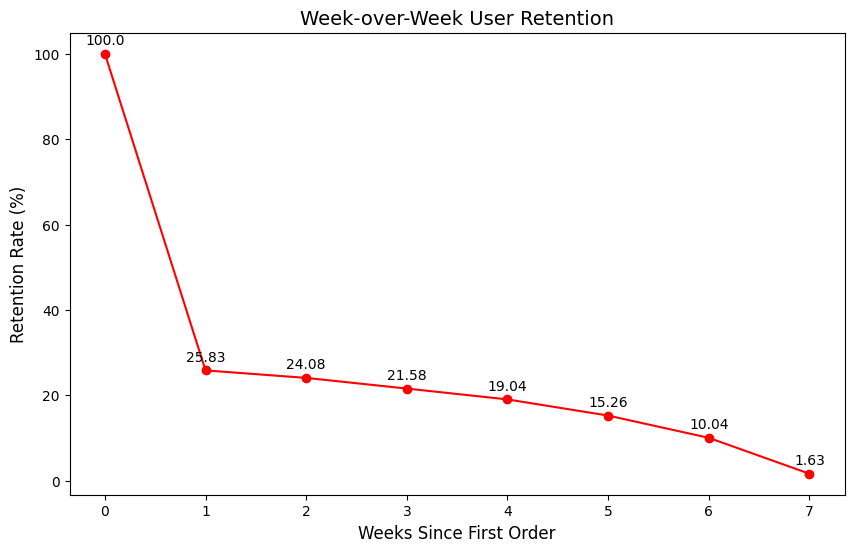

In [30]:
retention_df = create_retention_d(dps_post_treatment)
forecast_retention_df = estimated_retained_customers(dps_post_treatment, retention_df)
forecast_df = impact_summary(forecast_retention_df)
#forecast_df_final = impact_summary_w_cost(dps_post_treatment, forecast_df)

#plot_cumulative_incremental_profit(forecast_df_final)
#plot_cumulative_incremental_orders(forecast_df_final)

In [65]:
## Treatment Cities ##

entity_id = 'PO_FI'

city = ('Helsinki','Oulu')
city_str = ",".join([f"'{c}'" for c in city])

## post time period ##
start_date_post = '2024-08-16'
end_date_post = '2024-09-15'
dps_post = client.query(dps_all_f(city_str, entity_id, start_date_post, end_date_post)).to_dataframe()


## pre time period ##

# Convert the strings to datetime objects
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post, date_format)
end_date = datetime.strptime(end_date_post, date_format)

# Calculate the difference in days
days_difference = (end_date - start_date).days
days_difference

# Subtract the number of days from date1
new_date = start_date - timedelta(days=days_difference)
new_date_only = new_date.date()
new_date_string = new_date_only.strftime("%Y-%m-%d")

start_date_pre = new_date_string
end_date_pre = start_date_post
dps_pre = client.query(dps_all_f(city_str, entity_id, start_date_pre, end_date_pre)).to_dataframe()

cities_summary(dps_pre, dps_post)

entity_id_period,PO_FI_pre,PO_FI_post,percentage_change
Acquistions,63335,60946,-4.0
FDNC_cost_eur,54365,101979,88.0
FLGP_eur,67730,38118,-44.0
GFV_eur,3434797,3245344,-6.0
Orders,133050,130568,-2.0
Stacked_orders,4113,11193,172.0
Voucher_cost_eur,164613,208700,27.0
total_acquistion_cost,218978,310679,42.0


In [66]:
print(user_retention_wow(dps_pre))
print(user_retention_wow(dps_post))

   week_diff  users_retained  wow_retention
0          0           63335         100.00
1          1           13505          21.32
2          2           10763          16.99
3          3            6888          10.88
4          4            1483           2.34
   week_diff  users_retained  wow_retention
0          0           60946         100.00
1          1           13121          21.53
2          2           10956          17.98
3          3            7782          12.77
4          4            2258           3.70


In [67]:
post_sessions = client.query(sessions(entity_id, city_str, start_date_post, end_date_post)).to_dataframe()
pre_sessions = client.query(sessions(entity_id, city_str, start_date_pre, end_date_pre)).to_dataframe()

print(post_sessions , pre_sessions)

   total_sessions  total_users  total_orders      f0_
0          618466       206562         78415  0.12679    total_sessions  total_users  total_orders       f0_
0          601717       215443         78435  0.130352


In [68]:
## Control Cities ##

entity_id = 'PO_FI'

city = ('Tampere','Turku')
city_str = ",".join([f"'{c}'" for c in city])

## post time period ##
start_date_post = '2024-08-16'
end_date_post = '2024-09-15'
voucher_post_control = client.query(dps_all_f(city_str, entity_id, start_date_post, end_date_post)).to_dataframe()

## pre time period ##

# Convert the strings to datetime objects
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post, date_format)
end_date = datetime.strptime(end_date_post, date_format)

# Calculate the difference in days
days_difference = (end_date - start_date).days
days_difference

# Subtract the number of days from date1
new_date = start_date - timedelta(days=days_difference)
new_date_only = new_date.date()
new_date_string = new_date_only.strftime("%Y-%m-%d")

start_date_pre = new_date_string
end_date_pre = start_date_post
voucher_pre_control = client.query(dps_all_f(city_str, entity_id, start_date_pre, end_date_pre)).to_dataframe()

cities_summary(voucher_pre_control, voucher_post_control)

entity_id_period,PO_FI_pre,PO_FI_post,percentage_change
Acquistions,30688,33362,9.0
FDNC_cost_eur,36820,53411,45.0
FLGP_eur,91975,68904,-25.0
GFV_eur,1621454,1735436,7.0
Orders,66712,72212,8.0
Stacked_orders,1859,4578,146.0
Voucher_cost_eur,76526,103438,35.0
total_acquistion_cost,113346,156849,38.0


In [69]:
print(user_retention_wow(voucher_post_control))
print(user_retention_wow(voucher_pre_control))

   week_diff  users_retained  wow_retention
0          0           33362         100.00
1          1            7182          21.53
2          2            6137          18.40
3          3            4216          12.64
4          4            1322           3.96
   week_diff  users_retained  wow_retention
0          0           30688         100.00
1          1            6695          21.82
2          2            5507          17.95
3          3            3713          12.10
4          4             892           2.91


In [70]:
post_sessions = client.query(sessions(entity_id, city_str, start_date_post, end_date_post)).to_dataframe()
pre_sessions = client.query(sessions(entity_id, city_str, start_date_pre, end_date_pre)).to_dataframe()

print(post_sessions , pre_sessions)

   total_sessions  total_users  total_orders       f0_
0          303982        98498         40116  0.131968    total_sessions  total_users  total_orders       f0_
0          281904        99511         37858  0.134294
